### Do not run this, this is to process downloaded data, split and load to S3

In [1]:
%%time
import sagemaker
from sagemaker import get_execution_role
import os
import boto3 
import time
import shutil
import random

from PIL import Image

from sagemaker.analytics import ExperimentAnalytics
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

profile = 'sites'
region_name='us-east-2'
bucket = 'st-crayon-dev'

 
session = boto3.session.Session(profile_name = profile, region_name = region_name)
sess = sagemaker.Session(session,default_bucket=bucket)
print(sess.boto_session)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
Session(region_name='us-east-2')
CPU times: user 594 ms, sys: 797 ms, total: 1.39 s
Wall time: 6.18 s


In [2]:
sm = session.client(service_name = 'sagemaker')

experiment_name = f'site-tech-drone-img-seg'

experiments = []

for exp in Experiment.list(sagemaker_boto_client=sm):
    experiments.append(exp.experiment_name)

print(experiments)

if experiment_name not in experiments:
    experiment = Experiment.create(experiment_name=experiment_name,
                                   description="semantic segmentation of drone pictures",
                                   sagemaker_boto_client=sm)
experiment_name = experiments[0]                                   
print(f'Experiment used for notebook = {experiment_name}')


['site-tech-drone-img-seg']
Experiment used for notebook = site-tech-drone-img-seg


In [3]:
trial_name = f'unet--semantic-segmentation-{int(time.time())}'
ss_trial = Trial.create(trial_name = trial_name,
                          experiment_name = experiment_name,
                          sagemaker_boto_client = sm,
                          tags = [{'Key': 'experiment_name', 'Value': 'Unet'}])
ss_trial

Trial(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f6ab17f5c70>,trial_name='unet--semantic-segmentation-1595931241',experiment_name='site-tech-drone-img-seg',tags=[{'Key': 'experiment_name', 'Value': 'Unet'}],trial_arn='arn:aws:sagemaker:us-east-2:395166463292:experiment-trial/unet--semantic-segmentation-1595931241',response_metadata={'RequestId': '33dba54a-70c2-4835-a6d8-6f57106b0054', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '33dba54a-70c2-4835-a6d8-6f57106b0054', 'content-type': 'application/x-amz-json-1.1', 'content-length': '111', 'date': 'Tue, 28 Jul 2020 10:14:01 GMT'}, 'RetryAttempts': 0})

In [4]:
!pwd

/home/karan/site_tech/site_tech_drone_img_seg/notebooks


In [5]:
# /home/karan/site_tech/site_tech_drone_img_seg/data/raw/semantic_drone_dataset
# Create directory structure mimicing the s3 bucket where data is to be dumped.
DRONE_DATA = '../data/raw/semantic_drone_dataset'
os.makedirs(DRONE_DATA + '/train', exist_ok=True)
os.makedirs(DRONE_DATA + '/validation', exist_ok=True)
os.makedirs(DRONE_DATA + '/test', exist_ok=True)
os.makedirs(DRONE_DATA + '/train_annotation', exist_ok=True)
os.makedirs(DRONE_DATA + '/validation_annotation', exist_ok=True)
os.makedirs(DRONE_DATA + '/test_annotation', exist_ok=True)


In [6]:
images_path = DRONE_DATA + '/original_images'
mask_path = DRONE_DATA + '/label_images_semantic'
images = []
masks = []
for (dirpath, dirnames, filenames) in os.walk(images_path):
    print(dirpath)
    images.extend(filenames)

for (dirpath, dirnames, filenames) in os.walk(mask_path):
    print(dirpath)
    masks.extend(filenames)

../data/raw/semantic_drone_dataset/original_images
../data/raw/semantic_drone_dataset/label_images_semantic


In [7]:
[img[0:3]for img in images] == [msk[0:3]for msk in masks]

True

In [8]:
random.shuffle(images)
size = len(images)
train , val, test = int(.6 * size) , int(.15 *size), int(.25 * size)

print(train,val,test)

train_dataset = images[:train]
val_dataset = images[train:train+val]
test_dataset = images[train+val:]

print(len(train_dataset),len(val_dataset),len(test_dataset))

240 60 100
240 60 100


In [9]:
# Move the jpg images in training list to train directory and png images to train_annotation directory.
for i in train_dataset:
    shutil.copy2(images_path + '/' +i[:3] + '.jpg', DRONE_DATA + '/train/')
    shutil.copy2(mask_path + '/' +i[:3] + '.png', DRONE_DATA + '/train_annotation/')

# Move the jpg images in validation list to validation directory and png images to validation_annotation directory.
for i in val_dataset:
    shutil.copy2(images_path + '/' +i[:3] + '.jpg', DRONE_DATA + '/validation/')
    shutil.copy2(mask_path + '/' +i[:3] + '.png', DRONE_DATA + '/validation_annotation/')

# Move the jpg images in test list to test directory and png images to test_annotation directory.
for i in test_dataset:
    shutil.copy2(images_path + '/' +i[:3] + '.jpg', DRONE_DATA + '/test/')
    shutil.copy2(mask_path + '/' +i[:3] + '.png', DRONE_DATA + '/test_annotation/')

In [10]:
%%time
prefix = 'sagemaker/site_tech_drone_img_seg'
train_channel = prefix + '/train'
test_channel = prefix + '/test'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'
test_annotation_channel = prefix + '/test_annotation'

print(f'{train_channel} \n {validation_channel} \n {train_annotation_channel} \n {validation_annotation_channel} \
        \n {test_channel} \n {test_annotation_channel}')


sagemaker/site_tech_drone_img_seg/train 
 sagemaker/site_tech_drone_img_seg/validation 
 sagemaker/site_tech_drone_img_seg/train_annotation 
 sagemaker/site_tech_drone_img_seg/validation_annotation         
 sagemaker/site_tech_drone_img_seg/test 
 sagemaker/site_tech_drone_img_seg/test_annotation
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 101 µs


In [14]:
DRONE_DATA

'../data/raw/semantic_drone_dataset'

In [39]:
%%time
from PIL import Image
def compress_img(images_path, mask_path):
    INTERIM_DATA = '../data/interim/semantic_drone_dataset'
    print(f'{images_path=} {mask_path=}')
    images = []
    masks = []
    for (dirpath, dirnames, filenames) in os.walk(images_path):
        # print(dirpath)
        images.extend(filenames)
    
    for (dirpath, dirnames, filenames) in os.walk(mask_path):
        # print(dirpath)
        masks.extend(filenames)

    print(f'{len(images)}  {len(masks)}')

    for f in images:
        filepath = f'{images_path}/{f}'   
        folder = filepath.split('/')[4]
        print(INTERIM_DATA + '/' + folder + '/' + f)
        img = Image.open(filepath)
        new_img = img.resize((512,512))
        new_img.save(INTERIM_DATA + '/' + folder + '/' + f, "JPEG", optimize=True)
    
    for f in masks:
        filepath = f'{mask_path}/{f}'   
        folder = filepath.split('/')[4]
        print(INTERIM_DATA + '/' + folder + '/' + f)
        img = Image.open(filepath)
        new_img = img.resize((512,512))
        new_img.save(INTERIM_DATA + '/' + folder + '/' + f, "PNG", optimize=True)
    

train_data = DRONE_DATA + '/train'
train_annotation_data = DRONE_DATA + '/train_annotation'

validation_data = DRONE_DATA + '/validation'
validation_annotation_data = DRONE_DATA + '/validation_annotation'

test_data = DRONE_DATA + '/test'
test_annotation_data = DRONE_DATA + '/test_annotation'

compress_img(train_data,train_annotation)
compress_img(validation_data,validation_annotation_data)
compress_img(test_data,test_annotation_data)

set/test_annotation'
173  173
../data/interim/semantic_drone_dataset/test/000.jpg
../data/interim/semantic_drone_dataset/test/001.jpg
../data/interim/semantic_drone_dataset/test/002.jpg
../data/interim/semantic_drone_dataset/test/004.jpg
../data/interim/semantic_drone_dataset/test/015.jpg
../data/interim/semantic_drone_dataset/test/016.jpg
../data/interim/semantic_drone_dataset/test/031.jpg
../data/interim/semantic_drone_dataset/test/041.jpg
../data/interim/semantic_drone_dataset/test/044.jpg
../data/interim/semantic_drone_dataset/test/047.jpg
../data/interim/semantic_drone_dataset/test/052.jpg
../data/interim/semantic_drone_dataset/test/060.jpg
../data/interim/semantic_drone_dataset/test/065.jpg
../data/interim/semantic_drone_dataset/test/070.jpg
../data/interim/semantic_drone_dataset/test/073.jpg
../data/interim/semantic_drone_dataset/test/074.jpg
../data/interim/semantic_drone_dataset/test/077.jpg
../data/interim/semantic_drone_dataset/test/080.jpg
../data/interim/semantic_drone_dat

In [40]:
# upload the appropraite directory up to s3 respectively for all directories.
INTERIM_DATA = '../data/interim/semantic_drone_dataset'
sess.upload_data(path=INTERIM_DATA + '/train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path=INTERIM_DATA + '/validation', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path=INTERIM_DATA + '/test', bucket=bucket, key_prefix=test_channel)

sess.upload_data(path=INTERIM_DATA + '/train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path=INTERIM_DATA + '/validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)
sess.upload_data(path=INTERIM_DATA + '/test_annotation', bucket=bucket, key_prefix=test_annotation_channel)

# sess.upload_data(path='train_label_map.json', bucket=bucket, key_prefix=label_map_channel)

's3://st-crayon-dev/sagemaker/site_tech_drone_img_seg/test_annotation'

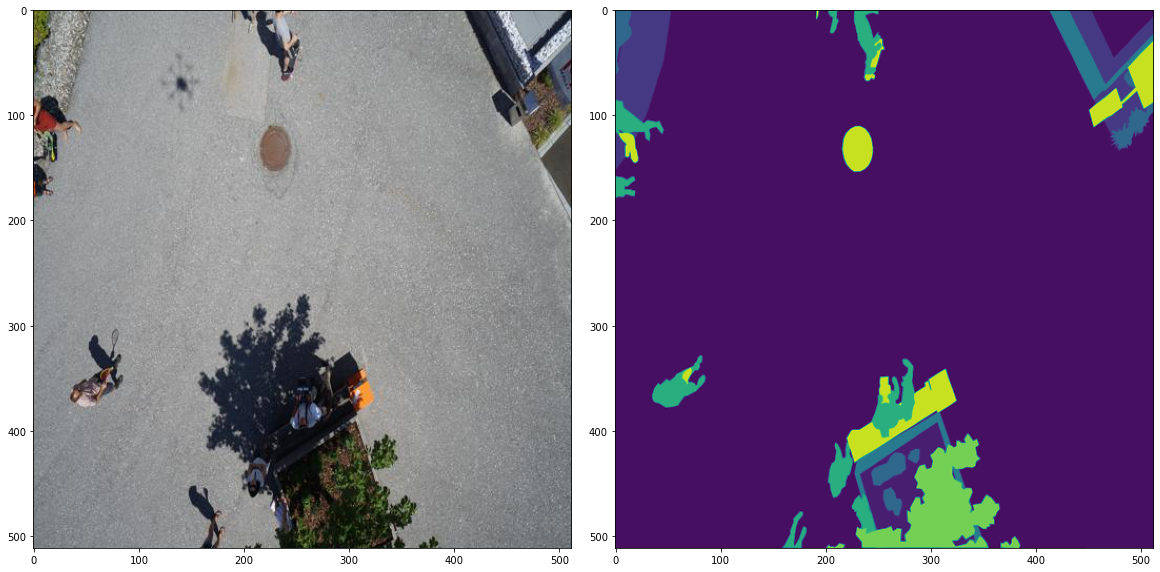

In [41]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
DRONE_DATA = '../data/raw/semantic_drone_dataset'
original_image = '../data/raw/semantic_drone_dataset/compressed/000.jpg'
label_image_semantic = '../data/raw/semantic_drone_dataset/compressed/000.png'
# data/raw/semantic_drone_dataset/train_annotation/163.jpg

fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

axs[0].imshow( Image.open(original_image))
axs[0].grid(False)

label_image_semantic = Image.open(label_image_semantic)
label_image_semantic = np.asarray(label_image_semantic)
axs[1].imshow(label_image_semantic)
axs[1].grid(False)

In [43]:
label_image_semantic

array([[6, 8, 8, ..., 1, 1, 1],
       [6, 8, 8, ..., 1, 1, 1],
       [6, 8, 8, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

In [44]:
np.unique(label_image_semantic)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24], dtype=uint8)

In [45]:
len(np.unique(label_image_semantic))

25